In [1]:
import numpy as np

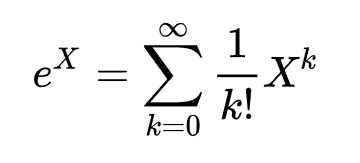

In [2]:
def emv_naive(A, vec, iters): #exp mul vec
    result = vec
    for i in range(iters-1):
        coef = iters - i - 1
        if coef == 0:
            coef = 1
        result = A @ result / coef + vec
    return result

In [3]:
A = np.eye(3)
v = np.array([1, 0, 0])

In [4]:
print(emv_naive(A, v, 5))

[2.70833333 0.         0.        ]


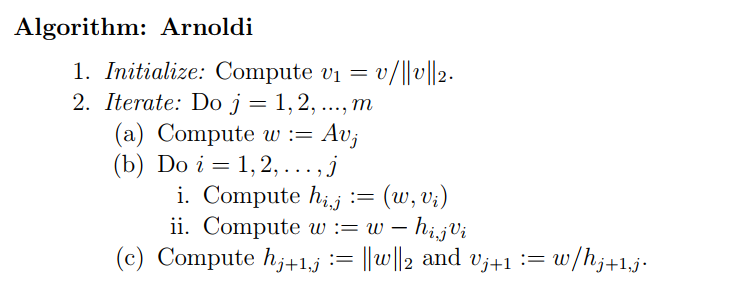

In [5]:
def basis_arnoldi(A, vec, m):
    #m = 1
    h = np.zeros([m+1, m+1])
    v = []
    v.append(vec / np.linalg.norm(vec))

    for j in range(m):
        w = A @ v[j]
        for i in range(j+1):
            h[i][j] = np.dot(w, v[i])
            w = w - h[i][j] * v[i]

        h[j+1][j] = np.linalg.norm(w)
        if h[j+1][j] == 0:
            h = h[:j+1,:j+1]
            break
        new_v = w / h[j+1][j]

        v.append(new_v)

    return v[:m],h[:m,:m]

In [6]:
v, h = basis_arnoldi([[1,2],[3,4]], [1,2], 1)

In [7]:
np.array(v).T

array([[0.4472136 ],
       [0.89442719]])

In [8]:
h

array([[5.4]])

In [9]:
basis_arnoldi(A, [1,2,3], 5)

([array([0.26726124, 0.53452248, 0.80178373])], array([[1.]]))

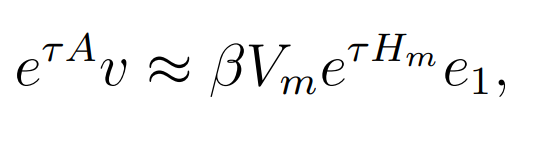

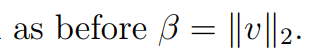

In [10]:
def emv_arnoldi(A, vec, m, iter):
    v, h = basis_arnoldi(A, vec, m)
    v = np.array(v).T

    beta = np.linalg.norm(vec)
    #print(np.shape(h))
    #print(v.shape, h.shape, beta.shape)
    ans = beta * (v @ emv_naive(h, np.eye(np.shape(h)[0], 1), iter))

    return ans

In [11]:
A = np.eye(3)
v = np.array([1, 0, 0])

In [12]:
emv_naive(A, v, 5)

array([2.70833333, 0.        , 0.        ])

In [13]:
emv_arnoldi(A, v, 1, 5)

array([[2.70833333],
       [0.        ],
       [0.        ]])

In [71]:
N = 10000

A = np.random.random((N,N))
v = np.random.random((N))

A /= np.linalg.norm(A)
v /= np.linalg.norm(v)

In [62]:
%timeit ans_naive = emv_naive(A, v, 12)

127 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [63]:
%timeit ans_arnoldi = emv_arnoldi(A, v, 6, 15)

538 µs ± 118 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [72]:
ans_naive = emv_naive(A, v, 12)

In [73]:
ans_naive100 = emv_naive(A, v, 100)

In [74]:
ans_arnoldi = emv_arnoldi(A, v, 6, 15)

In [67]:
import scipy
ans_scipy = scipy.linalg.expm(A) @ v

In [68]:
print(f"naive norm {np.linalg.norm(ans_naive)}")
print(f"naive100 norm {np.linalg.norm(ans_naive100)}")
print(f"scipy norm {np.linalg.norm(ans_scipy)}")
print(f"arnoldi norm {np.linalg.norm(ans_arnoldi)}")

naive norm 2.160233772241231
naive100 norm 2.1602337725846756
scipy norm 2.1602337725846756
arnoldi norm 2.160233772584572


In [69]:
def calculate_relative_error(true, pred):
    return np.linalg.norm(true - pred) / np.linalg.norm(pred)

In [70]:
print(f"relative error arnoldi with scipy {calculate_relative_error(ans_scipy, ans_arnoldi.T)}")
print(f"relative error naive100 with scipy {calculate_relative_error(ans_scipy, ans_naive100)}")
print(f"relative error naive6 with scipy {calculate_relative_error(ans_scipy, ans_naive)}")

relative error arnoldi with scipy 8.930921639442288e-11
relative error naive100 with scipy 1.9111339465031615e-16
relative error naive6 with scipy 1.62718060566538e-10


USE IN SOC

In [29]:
import numpy as np
import torch
import torch.nn.functional as F

In [30]:
%load_ext line_profiler

In [34]:
z = torch.load("z.pt")
curr_z = z

In [33]:
conv_filter_n = torch.load("conv_filter_n.pt")

In [35]:
num_terms = 5

In [36]:
kernel_size=3

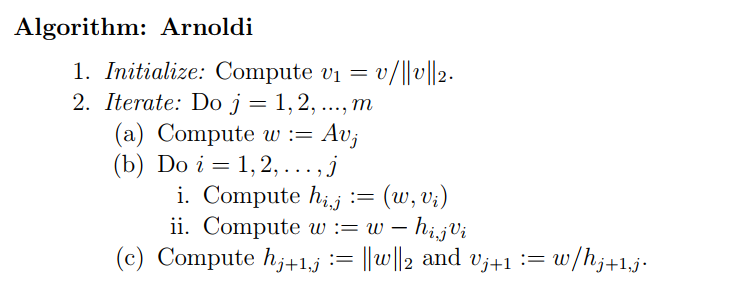


In [24]:

def basis_arnoldi_conv(L, X, m, kernel_size):
    #X - image tensot B x M x H x W
    #L - filter M x M x Kh x Kw
    #m - number of iters
    #return list of v and h for every element in batch B

    h = torch.zeros([X.shape[0], m+1, m+1]).half().cuda()
    norms = torch.linalg.norm(torch.linalg.norm(X, dim=(-1,-2)), dim=-1).half()
    v = torch.einsum('bijk,b->bijk', X, 1/norms)[None,:,:,:,:]
    for j in range(m):
        w  = F.conv2d(v[j].half(), L, padding=(kernel_size//2, kernel_size//2)).half()
        for i in range(j+1):
            h[:,i,j] = torch.einsum("bijk,bijk->b", w, v[i]).half()
            w = w - torch.einsum("b,bijk->bijk", h[:,i,j], v[i].cuda()).half()

        h[:,j+1,j] = torch.linalg.norm(torch.linalg.norm(w, dim=-1), dim=(-1,-2))
        
        new_v = torch.einsum("bijk,b->bijk", w, 1/h[:,j+1,j])
        v = torch.cat((v, new_v[None,:,:,:,:]))
        

    return v[:m],h[:,:m,:m]

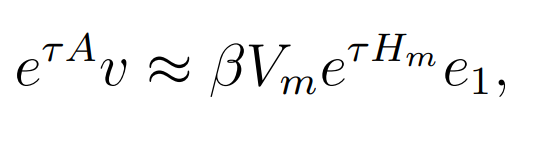

In [25]:
def emv_naive_conv(L, X, iters, kernel_size): #exp mul vec
    curr_z = X
    z = curr_z
    for i in range(1, iters+1):
        curr_z = F.conv2d(curr_z, L, 
                            padding=(kernel_size//2, 
                                    kernel_size//2))/float(i)
        z = z + curr_z
    return z

In [26]:
def emv_naive_batch(A, vec, iters):
    result = vec
    for i in range(iters-1):
        coef = iters - i - 1
        if coef == 0:
            coef = 1
        result = vec + torch.einsum("bij,bj->bi", A, result) / coef
    return result

In [29]:
def emv_arnoldi_conv(L, X, m, kernel_size, iter):
    v, h = basis_arnoldi_conv(L, X, m, kernel_size)

    beta = torch.linalg.norm(torch.linalg.norm(X, dim=(-1,-2)), dim=-1).half()

    v = torch.permute(v, (1,0,2,3,4))

    vec = torch.zeros((h.shape[0], h.shape[1])).cuda().half()
    vec[:,0] = 1

    exp = emv_naive_batch(h, vec, iter)

    ans = torch.einsum("blijk,bl,b->bijk", v, exp, beta) 

    return ans

In [18]:
curr_z = z
res = emv_arnoldi_conv(conv_filter_n, curr_z, 3, kernel_size, 10)

beta shape: torch.Size([128])
v shape: torch.Size([128, 3, 64, 16, 16])
h shape: torch.Size([128, 3, 3])
exp shape: torch.Size([128, 3])


In [35]:
curr_z = z
z1 = curr_z
for i in range(1, num_terms+1):
    curr_z = F.conv2d(curr_z, conv_filter_n, 
                        padding=(kernel_size//2, 
                                kernel_size//2))/float(i)
    z1 = z1 + curr_z

In [5]:
import numpy as np

def parse_logs(name):
    f = open(name, "r")
    line = f.readline()
    line = f.readline()


    time = []
    train_accuracy = []
    test_accuracy = []
    test_robust36 = []

    while(len(line) > 0):
        line = f.readline()
        vals = line.split(' 	 ')
        if len(vals) < 11:
            break
        time.append(float(vals[1]))
        train_accuracy.append(float(vals[4]))
        test_accuracy.append(float(vals[6]))
        test_robust36.append(float(vals[7]))
    return train_accuracy, test_accuracy, test_robust36, np.median(time)


In [2]:
train_accuracy_arn, test_accuracy_arn, test_robust36_arn = \
    parse_logs("/home/alexander/Downloads/Telegram Desktop/output (4).log")


In [3]:
train_accuracy_naive, test_accuracy_naive, test_robust36_naive = \
    parse_logs("/home/alexander/HSE/matexp_approximation/SOC/LipConvnet_cifar10_3_soc_32_maxmin_cr0.0/output.log")


In [4]:
len(test_accuracy_arn)

82

In [5]:
N = 79

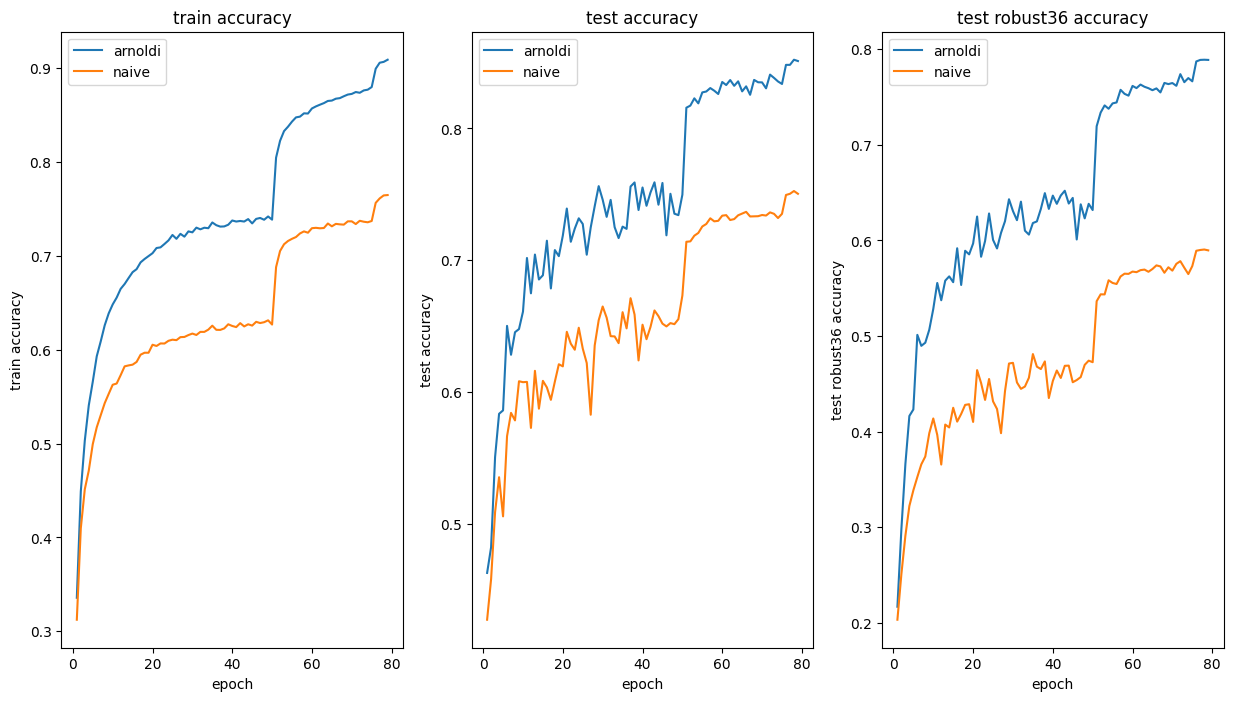

In [6]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1, 3, figsize=(15,8))

line1, = ax[0].plot(list(range(1,N+1)), train_accuracy_arn[:N], label="arnoldi")
line2, = ax[0].plot(list(range(1,N+1)), train_accuracy_naive[:N], label="naive")
ax[0].legend(handles=[line1, line2])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train accuracy")
#ax.set_yscale('log')
ax[0].set_title('train accuracy')

line1, = ax[1].plot(list(range(1,N+1)), test_accuracy_arn[:N], label="arnoldi")
line2, = ax[1].plot(list(range(1,N+1)), test_accuracy_naive[:N], label="naive")
ax[1].legend(handles=[line1, line2])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("test accuracy")
#ax.set_yscale('log')
ax[1].set_title('test accuracy')

line1, = ax[2].plot(list(range(1,N+1)), test_robust36_arn[:N], label="arnoldi")
line2, = ax[2].plot(list(range(1,N+1)), test_robust36_naive[:N], label="naive")
ax[2].legend(handles=[line1, line2])
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("test robust36 accuracy")
#ax.set_yscale('log')
ax[2].set_title('test robust36 accuracy')
plt.show()

In [37]:
print(np.finfo(np.float16).eps)


0.000977


**Experiments with time efficiency**

Time and metrics for standard SOC LipConvNet5 with 12 terms on inference and k terms while training

In [6]:
train_accuracy = []
test_accuracy = []
test_robust36 = []
time = []
num_terms = [1,2,3,4,5,10,12]

In [7]:
import os

path = "/home/alexander/HSE/matexp_approximation/SOC/logs/standard_Lip5_CIFAR10"

for file in sorted(os.listdir(path)):
    path_to_file = os.path.join(path, file)
    train_accuracy_, test_accuracy_, test_robust36_, time_ = parse_logs(path_to_file)
    train_accuracy.append(train_accuracy_)
    test_accuracy.append(test_accuracy_)
    test_robust36.append(test_robust36_)
    time.append(time_)

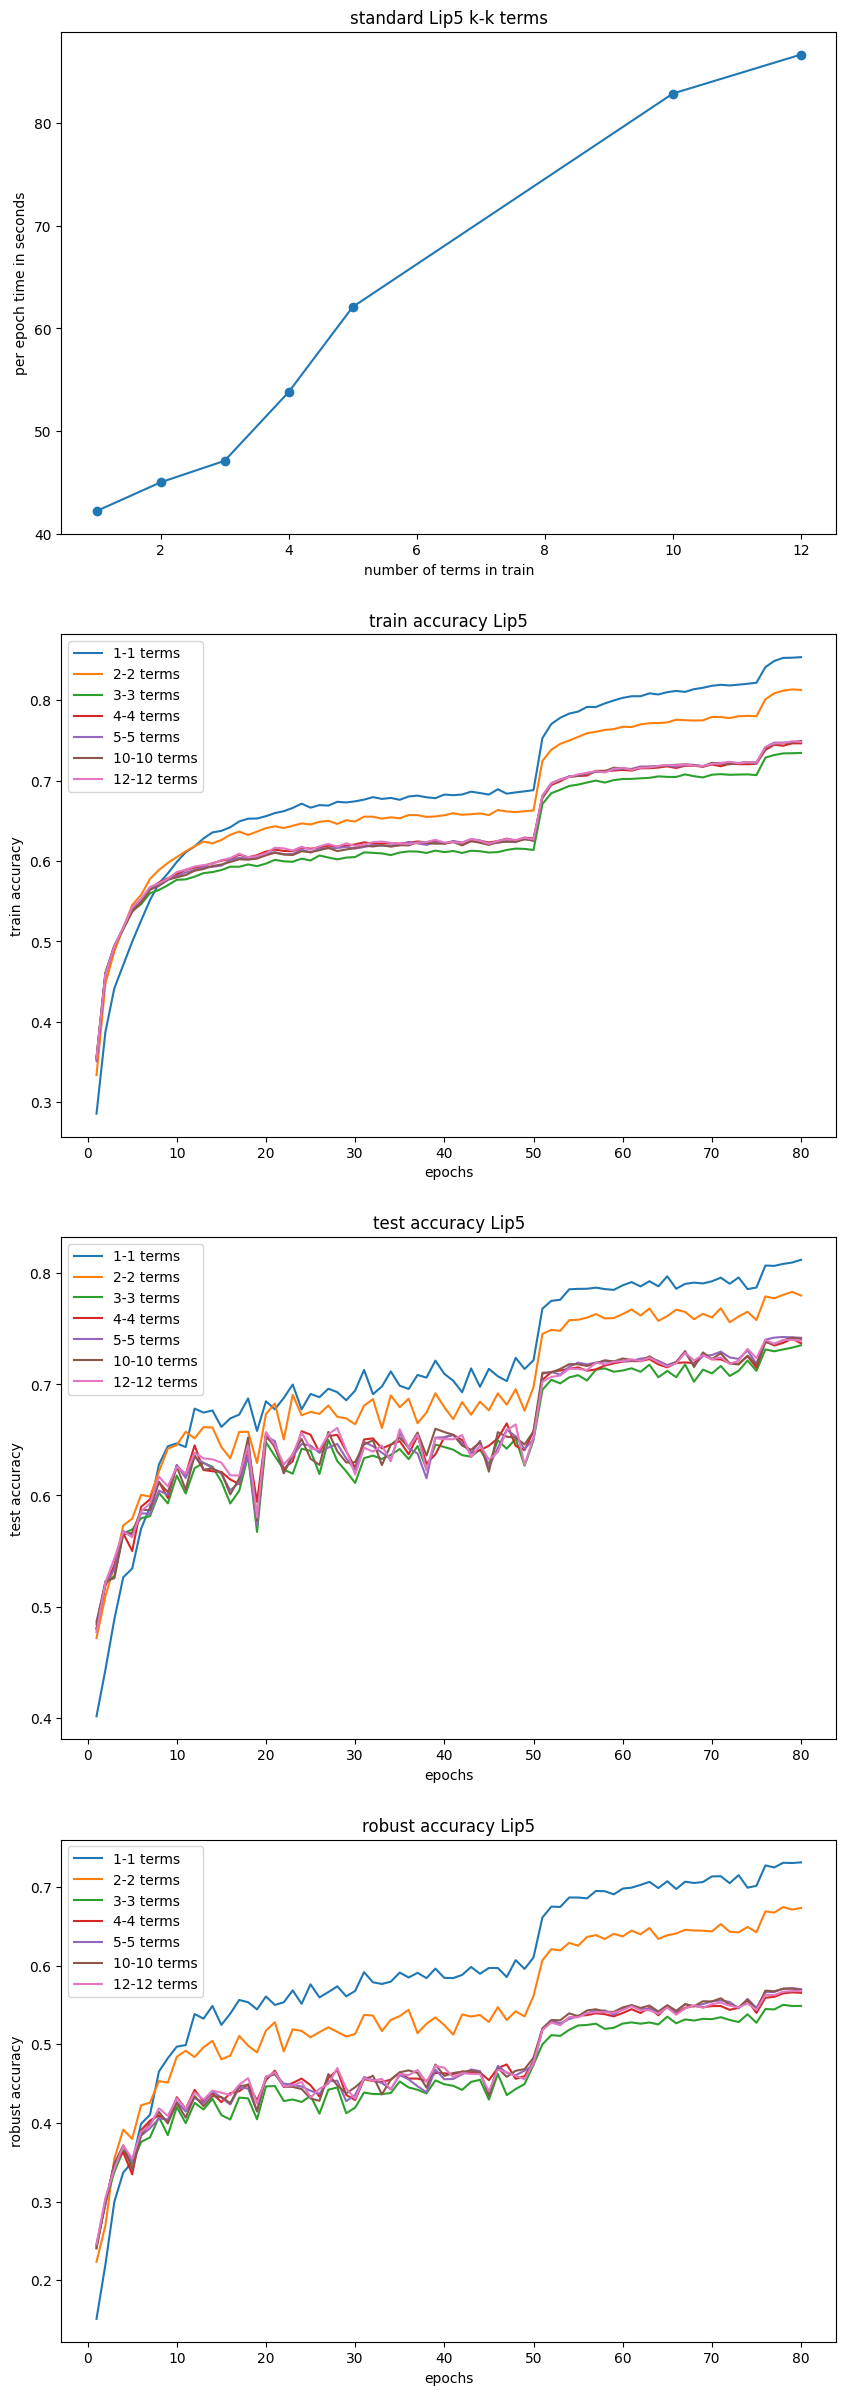

In [10]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(4, 1, figsize=(10,30))



N=80

line, = ax[0].plot(num_terms, time, marker='o')
ax[0].set_xlabel("number of terms in train")
ax[0].set_ylabel("per epoch time in seconds")
ax[0].set_title('standard Lip5 k-k terms')

ax[1].set_xlabel("epochs")
ax[1].set_ylabel("train accuracy")
ax[1].set_title('train accuracy Lip5')

for i, train_accuracy_ in enumerate(train_accuracy):

    line, = ax[1].plot(list(range(1,N+1)), train_accuracy_[:N], label=str(num_terms[i]) + '-' + str(num_terms[i]) + ' terms')

ax[1].legend()


ax[2].set_xlabel("epochs")
ax[2].set_ylabel("test accuracy")
ax[2].set_title('test accuracy Lip5')

for i, test_accuracy_ in enumerate(test_accuracy):

    line, = ax[2].plot(list(range(1,N+1)), test_accuracy_[:N], label=str(num_terms[i]) + '-' + str(num_terms[i]) + ' terms')

ax[2].legend()


ax[3].set_xlabel("epochs")
ax[3].set_ylabel("robust accuracy")
ax[3].set_title('robust accuracy Lip5')

for i, robust_accuracy_ in enumerate(test_robust36):

    line, = ax[3].plot(list(range(1,N+1)), robust_accuracy_[:N], label=str(num_terms[i]) + '-' + str(num_terms[i]) + ' terms')

ax[3].legend()


plt.show()

In [2]:
data = [ #arnoldi
0.136296, 66.8, 96.2,
0.150914, 66.2, 96.1,
0.144918, 65.8, 96.0, 
0.146646, 65.0, 96.1,
0.156966, 63.9, 95.7,
0.150861, 63.4, 96.1,
0.153378, 62.4, 96.2,
0.156748, 61.6, 96.2,
0.161554, 60.8, 96.3,
0.170639, 59.3, 96.3,
0.167805, 58.1, 96.4,
0.188182, 54.4, 96.1,
0.173848, 55.7, 96.4,
0.177722, 54.5, 96.5,
0.191321, 53.2, 96.6,

]

In [9]:
time_in_sec = data[0::3]
percent_of_basis = data[2::3]
percent_of_convs = data[1::3]

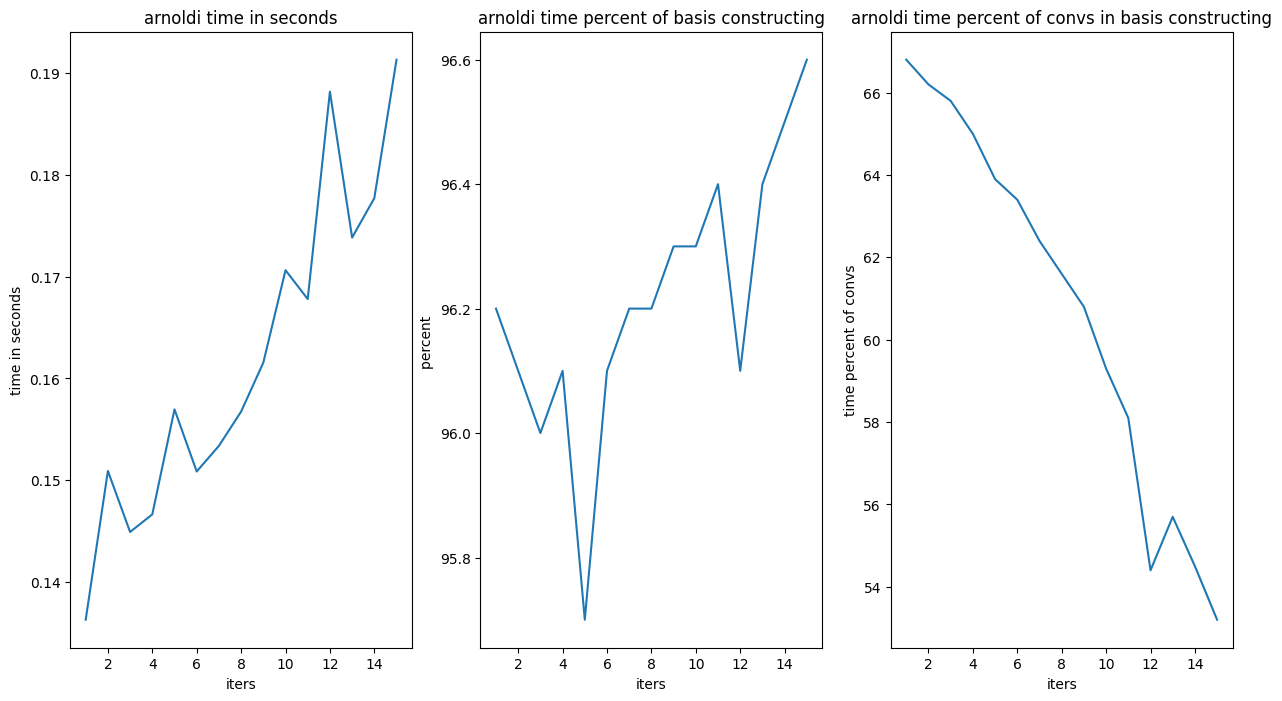

In [11]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1, 3, figsize=(15,8))

N=15

line, = ax[0].plot(list(range(1,N+1)), time_in_sec)
ax[0].set_xlabel("iters")
ax[0].set_ylabel("time in seconds")
ax[0].set_title('arnoldi time in seconds')

line, = ax[1].plot(list(range(1,N+1)), percent_of_basis)
ax[1].set_xlabel("iters")
ax[1].set_ylabel("percent ")
ax[1].set_title('arnoldi time percent of basis constructing')

line, = ax[2].plot(list(range(1,N+1)), percent_of_convs)
ax[2].set_xlabel("iters")
ax[2].set_ylabel("time percent of convs")
ax[2].set_title('arnoldi time percent of convs in basis constructing')
plt.show()

Experiment with number of zeros

In [12]:
original = [0.8125, 4.76837158203125e-07, 0.0, 0.0, 2.86102294921875e-06, 2.0503997802734375e-05, 0.00011873245239257812, 0.0006794929504394531, 0.005982398986816406, 0.04393959045410156, 0.3942122459411621, 0.9929003715515137, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


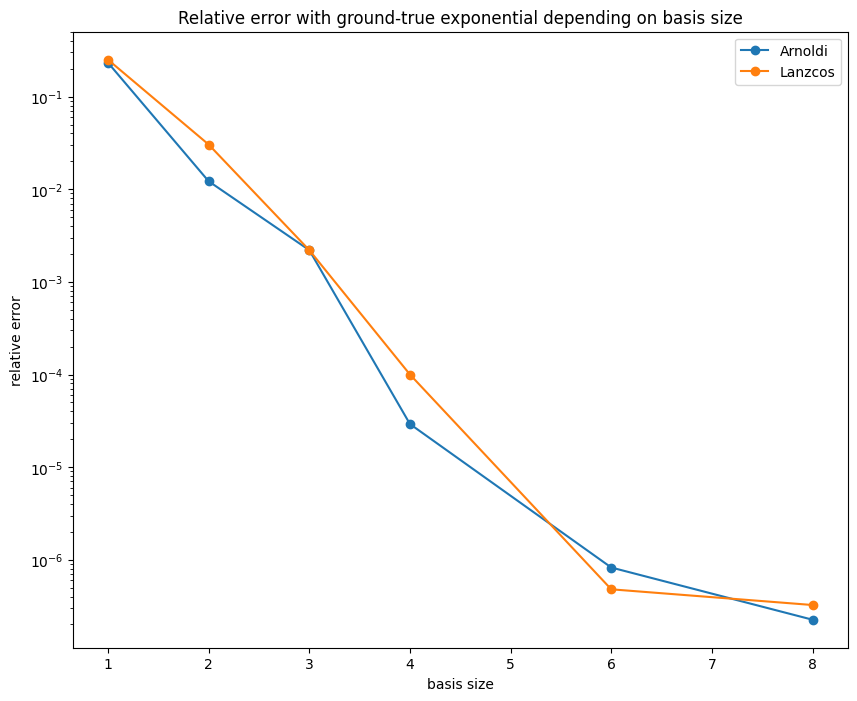

In [79]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1, 1, figsize=(10,8))

terms = [1,2,3,4,6,8]

arnoldi_err_exp = [0.2324, 0.0122, 0.0022, 2.9194e-05, 8.2459e-07, 2.2520e-07]
lanczos_err_exp = [0.2503, 0.0304, 0.0022, 0.0001, 4.7967e-07, 3.2459e-07]

ax.set_xlabel("basis size")
ax.set_ylabel("relative error")
ax.set_title('Relative error with ground-true exponential depending on basis size')

ax.set_yscale('log')

line, = ax.plot(terms, arnoldi_err_exp, label = "Arnoldi", marker='o')
line, = ax.plot(terms, lanczos_err_exp, label = "Lanzcos", marker='o')

ax.legend()
